In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp -p /content/gdrive/MyDrive/Colab\ Notebooks/Final_dataset.zip /tmp/Dataset.zip

In [ ]:
!unzip /tmp/Dataset.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /Final_dataset/train_mask/train/TCGA-A2-A3XU-DX1_id-5ea40a69ddda5f839898f173_left-37424_top-26649_bottom-26924_right-37699.png  
  inflating: /Final_dataset/train_mask/train/TCGA-D8-A1JF-DX1_id-5ea40a71ddda5f839898f744_left-27667_top-54136_bottom-54393_right-27939.png  
  inflating: /Final_dataset/train_mask/train/TCGA-D8-A1JF-DX1_id-5ea40a71ddda5f839898f744_left-28431_top-53614_bottom-53902_right-28732.png  
  inflating: /Final_dataset/train_mask/train/TCGA-A2-A3XT-DX1_id-5ea409a1ddda5f839898268e_left-85345_top-30938_bottom-31217_right-85629.png  
  inflating: /Final_dataset/train_mask/train/TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-91393_top-189737_bottom-190030_right-91797.png  
  inflating: /Final_dataset/train_mask/train/TCGA-GM-A2DH-DX1_id-5ea40adcddda5f83989951a2_left-53266_top-59356_bottom-59647_right-53523.png  
  inflating: /Final_dataset/train_mask/train/TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-

In [ ]:
!pip install segmentation_models
!pip uninstall -y h5py

!pip install h5py==2.10.0
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import random

     |████████████████████████████████| 50 kB 4.8 MB/s 
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 4.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
Segmentation Models: using `keras` framework.


/Final_dataset/train_img/train/TCGA-GM-A2DD-DX1_id-5ea40aa8ddda5f8398992acd_left-53147_top-24711_bottom-24967_right-53416.png
Mask labels are:  [0 1]  and the counts are:  [55486 10050]


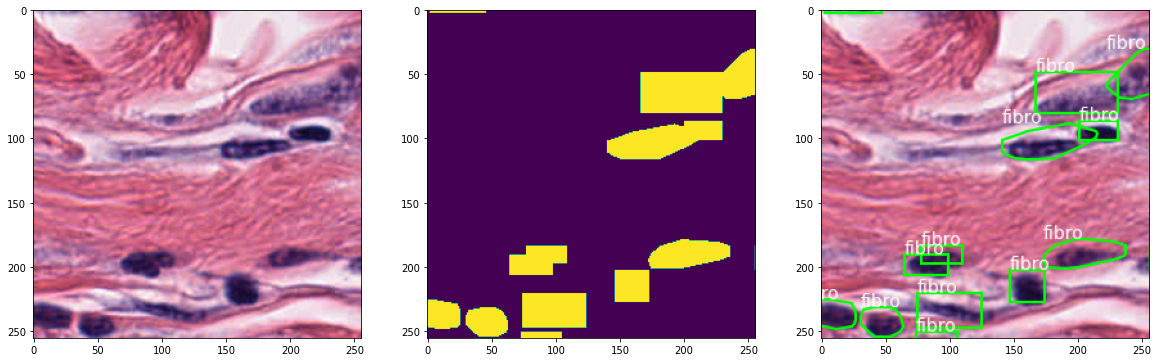

In [ ]:

train_img_dir = "/Final_dataset/train_img/train/"
train_mask_dir = "/Final_dataset/train_mask/train/"
train_vis_dir = "/Final_dataset/train_vis/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
print(train_img_dir+img_list[img_num])
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

vis_for_plot = cv2.imread(train_vis_dir+img_list[img_num], 1)
vis_for_plot = cv2.cvtColor(vis_for_plot, cv2.COLOR_BGR2RGB)

labels, count = np.unique(mask_for_plot, return_counts=True)
print("Mask labels are: ", labels, " and the counts are: ", count)

import matplotlib as mpl
mpl.rcParams["figure.figsize"]=(20,16)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img_for_plot)
axarr[1].imshow(mask_for_plot)
axarr[2].imshow(vis_for_plot)
plt.show()

In [ ]:
seed=24
batch_size= 8
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    #img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    #print(img)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(img_path, mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,vertical_flip=True,fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)



val_img_path = "/Final_dataset/val_img/"
val_mask_path = "/Final_dataset/val_mask/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

train_img_path = "/Final_dataset/train_img/"
train_mask_path = "/Final_dataset/train_mask/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)


!ls /Final_dataset/val_img/val/ | wc -l
!ls /Final_dataset/val_mask/val/ | wc -l
!ls /Final_dataset/train_img/train/ | wc -l
!ls /Final_dataset/train_mask/train/ | wc -l

175
175
1569
1569


Found 1569 images belonging to 1 classes.
Found 1569 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


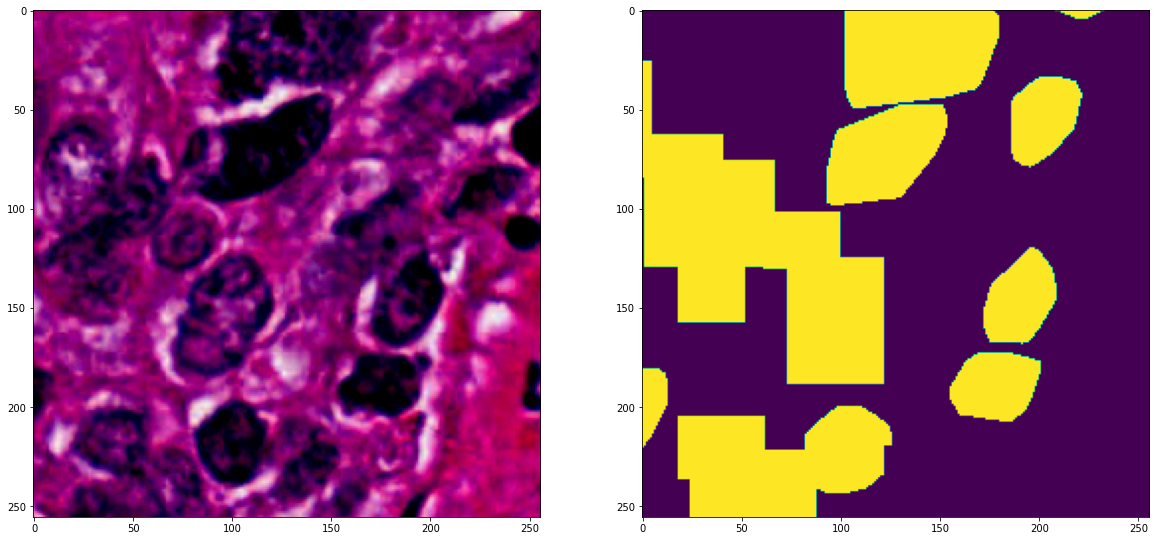

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


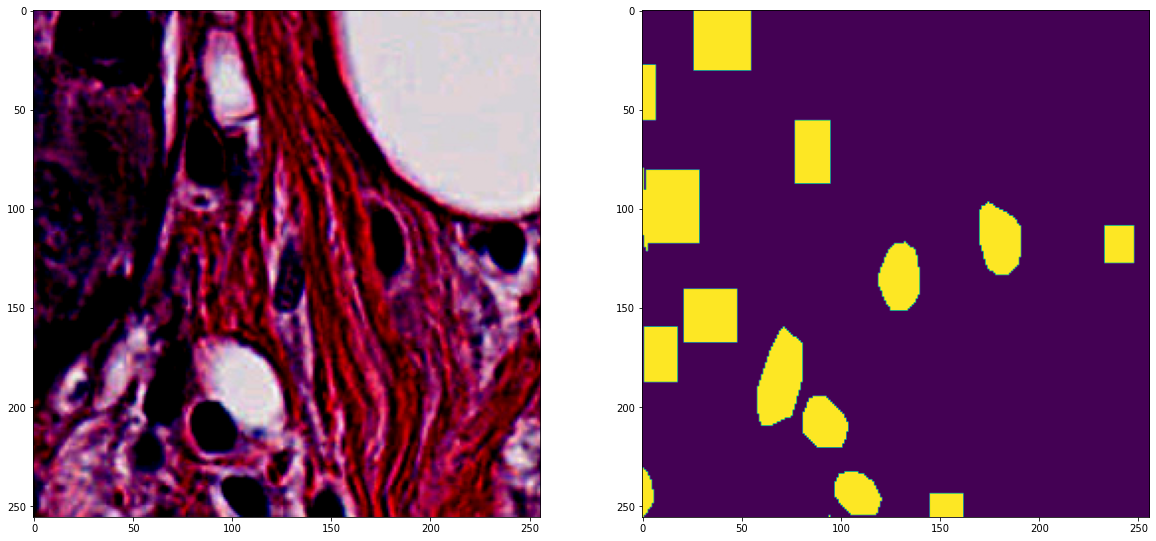

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


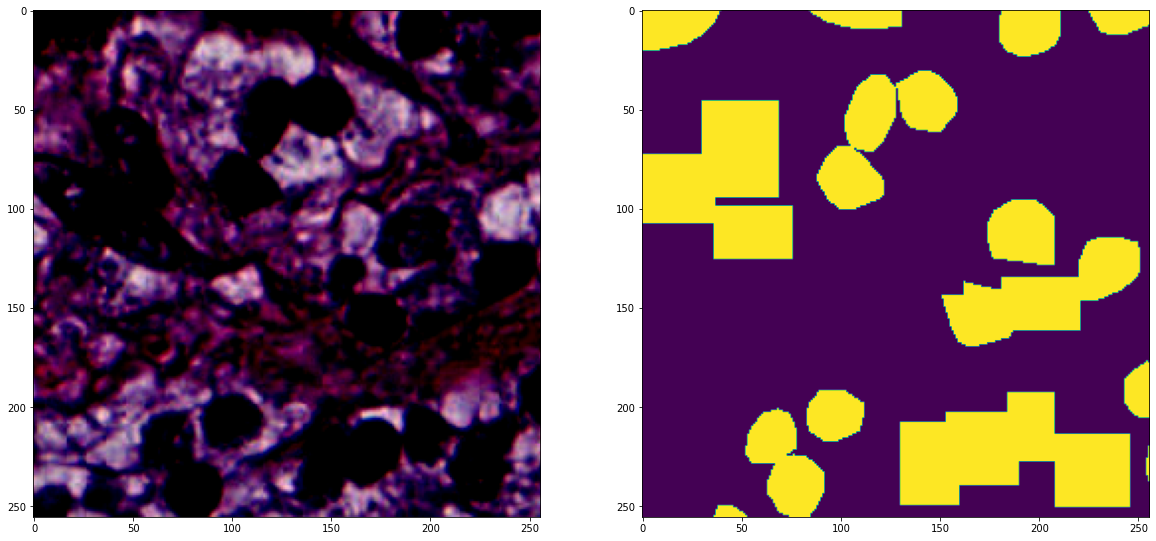

Found 175 images belonging to 1 classes.
Found 175 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


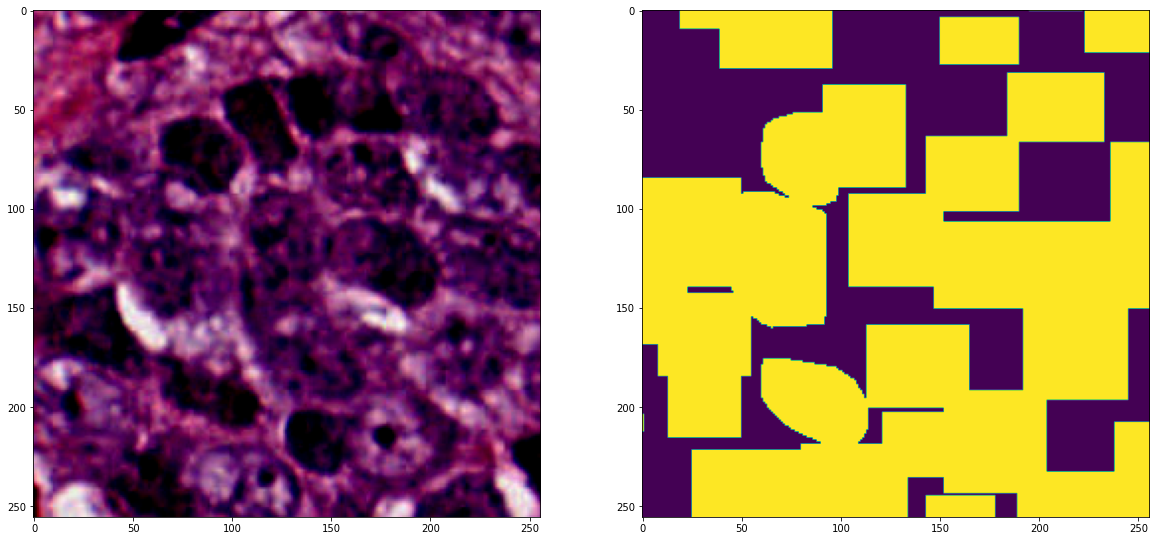

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


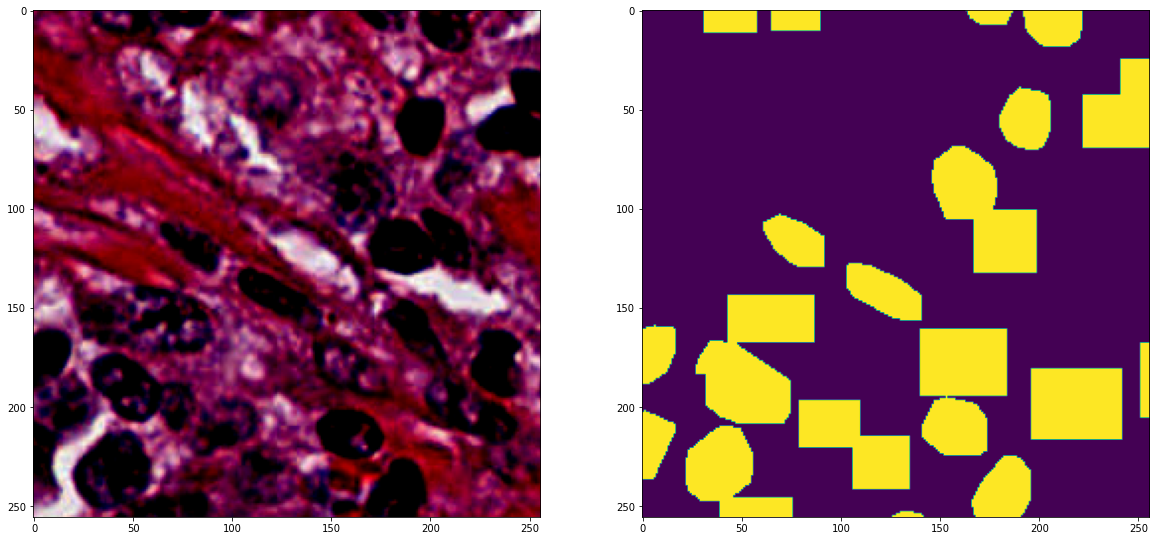

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


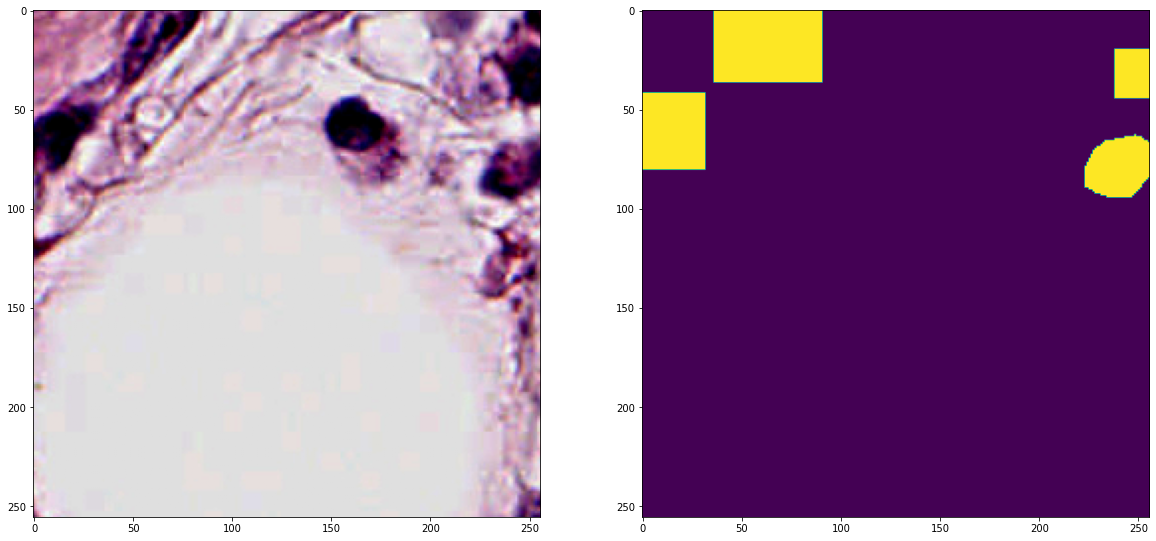

In [ ]:
x, y = train_img_gen.__next__()
for i in range(0,3):
    image = x[i]
    #print("x",i,"= ", x[i])
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

In [ ]:
val_image_path = "/Final_dataset/val_img/val/"
train_image_path = "/Final_dataset/train_img/train/"
num_train_imgs = len(os.listdir(train_image_path))
num_val_images = len(os.listdir(val_image_path))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=n_classes

print(num_train_imgs)
print(num_val_images)
print("steps_per_epoch for training: "+str(steps_per_epoch))
print("steps_per_epoch for validation: "+str(val_steps_per_epoch))

1569
175
steps_per_epoch for training: 196
steps_per_epoch for validation: 21


In [ ]:
# define model
sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights=None, 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, 
                activation='softmax')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
print(model.summary())
print("Input Shape",model.input_shape)
print("Output Shape",model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/100
196/196 [==============================] - 143s 573ms/step - loss: 0.5441 - iou_score: 0.4981 - val_loss: 0.8594 - val_iou_score: 0.2795
Epoch 2/100
196/196 [==============================] - 100s 512ms/step - loss: 0.4461 - iou_score: 0.5966 - val_loss: 0.5503 - val_iou_score: 0.5160
Epoch 3/100
196/196 [==============================] - 102s 521ms/step - loss: 0.4253 - iou_score: 0.6183 - val_loss: 0.4313 - val_iou_score: 0.6127
Epoch 4/100
196/196 [==============================] - 100s 510ms/step - loss: 0.4141 - iou_score: 0.6310 - val_loss: 0.4220 - val_iou_score: 0.6274
Epoch 5/100
196/196 [==============================] - 100s 510ms/step - loss: 0.4068 - iou_score: 0.6395 - val_loss: 0.4150 - val_iou_score: 0.6356
Epoch 6/100
196/196 [==============================] - 100s 509ms/step - loss: 0.4022 - iou_score: 0.6442 - val_loss: 0.4387 - val_iou_score: 0.6194
Epoch 7/100
196/196 [==============================] - 102s 518ms/step - loss: 0.4003 - iou_score: 0.6472 

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/cancer_100_epochs_InceptionV3_backbone_jac-foc_loss_batch8_2class.hdf5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Final_dataset.zipcancer_50_epochs_RESNET_backbone_jac-foc_loss_batch32_5class.hdf5', compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()